## Approach A

## Data (not augmented)

This section introduces the data handling approach for the project.
The code defines a custom PyTorch Dataset class, `AccentRawWaveformDataset`, which loads audio files from a specified folder,
applies optional mel-spectrogram transformations, and returns the resulting spectrogram along with the accent label and gender extracted from the filename. This dataset is designed to be used for training or evaluating models
on accent classification tasks using spectrogram representations of audio.


In [1]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset

class AccentRawWaveformDataset(Dataset):
    def __init__(self, folder_path,
                 target_sr: int = 16000,
                 standardize: bool = True):
        # store file paths only; transform per item
        self.file_paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.endswith('.wav')
        ]
        self.target_sr = target_sr
        self.standardize = standardize

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        waveform, sr = torchaudio.load(path)
        if sr != self.target_sr:
            waveform = torchaudio.transforms.Resample(sr, self.target_sr)(waveform)
        # Convert to mono if not already
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        # Standardize (zero mean, unit variance) if requested
        if self.standardize:
            mean = waveform.mean()
            std = waveform.std() if waveform.std() > 0 else 1.0
            waveform = (waveform - mean) / std

        fname = os.path.basename(path)
        accent = int(fname[0]) - 1          # classes 0–4
        gender = fname[1]  # 'm' or 'f' 
        return waveform, accent, gender

### pad_1d_collate

This section defines a custom collate function called `pad_1d_collate` for use with a PyTorch `DataLoader`.  
The function takes a batch of tuples (each containing a 1D waveform, accent label, and gender),  
pads or crops each waveform in the batch to a fixed length (`target_length`, default 208),  
and returns a batch of stacked waveform tensors, a tensor of accent labels, and a list of gender strings.  
This ensures that all waveforms in a batch have the same shape, which is required for efficient batching in PyTorch.

In [2]:
import torch.nn.functional as F

def pad_1d_collate(batch, target_length=208):
    waveforms, accents, genders = zip(*batch)
    padded_waveforms = []
    for w in waveforms:
        pad_amount = target_length - w.shape[-1]
        if pad_amount > 0:
            # Pad at the end (right side) for 1D waveform
            padded = F.pad(w, (0, pad_amount))
        else:
            padded = w[..., :target_length]
        padded_waveforms.append(padded)
    return (
        torch.stack(padded_waveforms),  # (B, 1, T)
        torch.tensor(accents),
        list(genders)
    )


Inspecting a sample

In [3]:
# Let's instantiate the dataset and inspect a sample
# (Assume the folder path is './data' - change as needed)
dataset = AccentRawWaveformDataset("/Users/larsheijnen/DL/Train")

print(f"Number of samples in dataset: {len(dataset)}")

# Get the first sample
sample_waveform, sample_accent, sample_gender = dataset[0]

print("Sample 0 waveform shape:", sample_waveform.shape)
print("Sample 0 accent label:", sample_accent)
print("Sample 0 gender label:", sample_gender)


Number of samples in dataset: 3166
Sample 0 waveform shape: torch.Size([1, 41400])
Sample 0 accent label: 1
Sample 0 gender label: m


### Data loader

This section sets up a PyTorch DataLoader to efficiently batch and shuffle data, using a small batch_size and a custom pad_collate function to pad or crop spectrograms so all inputs in a batch have the same shape. The resulting batches contain stacked spectrogram tensors, accent labels, and gender labels, ready for use in training or evaluation.

In [4]:
from torch.utils.data import DataLoader

# Use batch_size=4 for low RAM, pin_memory is False for macOS/MPS
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=pad_1d_collate, pin_memory=False)

# Try again
for batch in dataloader:
    waveforms, accents, gender = batch
    print(f"Waveforms: {waveforms.shape}")  # (B, 1, T)
    print(f"Accents: {accents}")            # (B,)
    print(f"Gender: {gender}")
    break

Waveforms: torch.Size([4, 1, 208])
Accents: tensor([2, 0, 1, 0])
Gender: ['m', 'm', 'f', 'f']


### Models

#### Overview

This code defines six variations of a simple Convolutional Neural Network (CNN) architecture in PyTorch, designed for multi-class classification (default: 5 classes, such as accent or gender prediction from spectrograms). Each model uses three convolutional layers, a global pooling layer to standardize feature map sizes, and a fully connected (linear) output layer. The variations explore the effects of batch normalization and dropout regularization on training stability and overfitting.

---

#### Model Structure

**Shared Core Design (all models):**

- **Convolutional Layers (`Conv2d`):**  
  Three stacked 2D convolutional layers with increasing channel depth (8 → 16 → 32), kernel size 3×3, and padding to keep feature map sizes consistent.

- **Activation (`ReLU`):**  
  Each convolution is followed by a ReLU activation for non-linearity.

- **Pooling (`AdaptiveAvgPool2d`):**  
  Shrinks feature maps to a fixed 16×16 size, allowing input spectrograms of varying dimensions.

- **Flattening:**  
  The pooled output is flattened to a 1D vector.

- **Fully Connected Layer (`Linear`):**  
  Maps extracted features to the desired number of classes.

---

#### Model Variants

1. **CNNBaseline**  
   The simplest model: just convolutions, activations, pooling, and a final linear layer.

2. **CNNBaseline_BatchNorm**  
   Adds batch normalization after each convolution (not after activation in the code), which stabilizes and speeds up training by normalizing layer inputs.

3. **CNNBaseline_Dropout3**  
   Adds a dropout layer (dropout probability 0.3) before the final linear layer to randomly zero some activations during training, helping prevent overfitting.

4. **CNNBaseline_Dropout5**  
   Same as above but with a higher dropout rate (0.5) for stronger regularization.

5. **CNNBaseline_Dropout3_BatchNorm**  
   Combines both batch normalization after each convolution and dropout (0.3) before the final layer.

6. **CNNBaseline_Dropout5_BatchNorm**  
   Combines batch normalization with a higher dropout rate (0.5).

---

#### Forward Pass Flow (for all models)

1. **Input:**  
   Receives a batch of spectrograms (e.g., `[B, 1, F, T]`).

2. **Conv → ReLU → [BatchNorm]:**  
   Processes input through three convolutional layers with ReLU activations; some models also normalize with batch normalization.

3. **Pooling:**  
   Reduces output to a fixed 16×16 feature map.

4. **Dropout (if included):**  
   Applies dropout regularization before classification.

5. **Flatten and Classify:**  
   Flattens the pooled feature map and passes it to the fully connected layer for prediction.

---

#### Why so many models?

Testing these variations helps determine which combination of normalization and regularization yields the best training stability and generalization for your particular data and task.


In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Model 1 (baseline)
class CNNBaseline(nn.Module):
    def __init__(self, num_classes: int = 5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(16)  # Output: (B, 32, 256)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        # x: (B, 1, T)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # (B, 32, 256)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 2 (baseline + batch normalization)
class CNNBaseline_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 3 (baseline + dropout 0.3)
class CNNBaseline_Dropout3(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 4 (baseline + dropout 0.5)
class CNNBaseline_Dropout5(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 5 (baseline + batch normalization + dropout 0.3)
class CNNBaseline_Dropout3_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 6 (baseline + batch normalization + dropout 0.5)
class CNNBaseline_Dropout5_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### Models_dict

This code creates a dictionary, models_dict, that links string keys (like "Model1", "Model2", etc.) to each CNN model class defined earlier.

In [6]:
models_dict = {
    "Model1": CNNBaseline,
    "Model2": CNNBaseline_BatchNorm, 
    "Model3": CNNBaseline_Dropout3,
    "Model4": CNNBaseline_Dropout5,
    "Model5": CNNBaseline_Dropout3_BatchNorm,
    "Model6": CNNBaseline_Dropout5_BatchNorm,}

### Model Training with Early Stopping (Non-Augmented Data)

This section trains and evaluates multiple CNN-based models using raw 1D waveform input data.  
It standardizes the waveforms, applies custom padding via `pad_1d_collate`, and uses a train/test split for supervised learning.

Each model is trained with early stopping based on validation accuracy, and performance metrics such as accuracy, precision, recall, and F1-score are logged for both training and testing phases.  
In addition, gender-specific evaluation and a full classification report are generated to assess model fairness and robustness across demographic groups.

In [7]:
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import os

# Prepare dataset & split
dataset = AccentRawWaveformDataset(
    '/Users/larsheijnen/DL/Train',
    target_sr=16000,
    standardize=True
)

train_len = int(0.8 * len(dataset))
test_len  = len(dataset) - train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=pad_1d_collate)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=pad_1d_collate)

device    = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

def evaluate(loader, model, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for specs, labels, _ in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    acc    = accuracy_score(all_labels, all_preds)
    prec   = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1     = f1_score(all_labels, all_preds, average='macro')
    return acc, prec, recall, f1

def evaluate_by_gender(loader, model, device):
    model.eval()
    all_preds, all_labels, all_genders = [], [], []
    with torch.no_grad():
        for specs, labels, genders in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            all_genders.extend(genders)
    results = {}
    for gender in ['m', 'f']:
        idxs = [i for i, g in enumerate(all_genders) if g == gender]
        gender_preds = [all_preds[i] for i in idxs]
        gender_labels = [all_labels[i] for i in idxs]
        acc = accuracy_score(gender_labels, gender_preds)
        prec = precision_score(gender_labels, gender_preds, average='macro', zero_division=0)
        recall = recall_score(gender_labels, gender_preds, average='macro')
        f1 = f1_score(gender_labels, gender_preds, average='macro')
        results[gender] = {'accuracy': acc, 'precision': prec, 'recall': recall, 'f1': f1}
    return results

def classification_report_for_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for specs, labels, _ in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(classification_report(all_labels, all_preds, digits=3))

# Early stopping parameters
patience = 20
max_epochs = 150
min_improvement = 0.005

save_dir_base = "/Users/larsheijnen/DL/saved_models/A/not_augmented_earlystop"
os.makedirs(save_dir_base, exist_ok=True)

for model_name, model_class in models_dict.items():
    model = model_class().to(device)
    print(f"\n=== Training model: {type(model).__name__} (Early Stopping) ===")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    best_test_acc = 0.0
    patience_counter = 0

    best_model_path = os.path.join(save_dir_base, f"{type(model).__name__}_not_augmented_best_1d_earlystop.pth")
    final_model_path = os.path.join(save_dir_base, f"{type(model).__name__}_not_augmented_latest_1d_earlystop.pth")

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for specs, labels, genders in train_loader:
            specs, labels = specs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(specs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute and print general metrics for this epoch (not by gender)
        train_acc, train_prec, train_recall, train_f1 = evaluate(train_loader, model, device)
        test_acc, test_prec, test_recall, test_f1 = evaluate(test_loader, model, device)
        print(
            f"Epoch {epoch+1:3d}/{max_epochs} | "
            f"Train Loss: {running_loss:.3f} | "
            f"Train Acc: {train_acc*100:5.2f}% | "
            f"Train Prec: {train_prec*100:5.2f}% | "
            f"Train Recall: {train_recall*100:5.2f}% | "
            f"Train F1: {train_f1*100:5.2f}% || "
            f"Test Acc: {test_acc*100:5.2f}% | "
            f"Test Prec: {test_prec*100:5.2f}% | "
            f"Test Recall: {test_recall*100:5.2f}% | "
            f"Test F1: {test_f1*100:5.2f}% | "
            f"Patience: {patience_counter}/{patience}"
        )

        if test_acc > best_test_acc + min_improvement:
            best_test_acc = test_acc
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"    → New best test accuracy: {best_test_acc*100:.3f}% (saved to {best_model_path})")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered for {type(model).__name__} after {epoch+1} epochs.")
            break

    torch.save(model.state_dict(), final_model_path)
    print(f"Final training state for {type(model).__name__} saved to {final_model_path}")
    print(f"\nTraining completed for {type(model).__name__} after {epoch+1} epochs.")
    print(f"Best test accuracy achieved during training: {best_test_acc*100:.3f}%")

    # Load the best model for final evaluation
    if os.path.exists(best_model_path):
        print(f"\nLoading best saved model for {type(model).__name__} from {best_model_path} for final evaluation...")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        eval_model_description = "best saved"
    else:
        print(f"\nNo best model was saved for {type(model).__name__}. Using final model state for evaluation.")
        eval_model_description = "final"

    print(f"\nClassification Report for {type(model).__name__} (using {eval_model_description} model):")
    classification_report_for_model(model, test_loader, device)

    print(f"\nGender breakdown for {type(model).__name__} (using {eval_model_description} model):")
    gender_results = evaluate_by_gender(test_loader, model, device)
    for gender in gender_results:
        label = "Male" if gender == "m" else "Female"
        print(f"{label}: {gender_results[gender]}")

    final_train_acc, _, _, _ = evaluate(train_loader, model, device)
    print(f"\n--- Summary for {type(model).__name__} ---")
    print(f"- Total epochs trained: {epoch+1}")
    print(f"- Best validation accuracy during training: {best_test_acc*100:.3f}%")
    print(f"- Training accuracy of loaded ({eval_model_description}) model: {final_train_acc*100:.2f}%")
    if os.path.exists(best_model_path):
        print(f"- Best model saved to: {best_model_path}")
    else:
        print(f"- Best model not saved (or final model is the best achieved). Final model at: {final_model_path}")
    print(f"---------------------------------------\n")

print("\nAll model configurations have been trained and evaluated.")


=== Training model: CNNBaseline (Early Stopping) ===
Epoch   1/150 | Train Loss: 1012.309 | Train Acc: 23.85% | Train Prec:  4.77% | Train Recall: 20.00% | Train F1:  7.70% || Test Acc: 23.66% | Test Prec:  4.73% | Test Recall: 20.00% | Test F1:  7.65% | Patience: 0/20
    → New best test accuracy: 23.659% (saved to /Users/larsheijnen/DL/saved_models/A/not_augmented_earlystop/CNNBaseline_not_augmented_best_1d_earlystop.pth)
Epoch   2/150 | Train Loss: 1011.110 | Train Acc: 23.82% | Train Prec:  4.76% | Train Recall: 19.97% | Train F1:  7.69% || Test Acc: 23.66% | Test Prec:  4.73% | Test Recall: 20.00% | Test F1:  7.65% | Patience: 0/20
Epoch   3/150 | Train Loss: 1010.694 | Train Acc: 23.78% | Train Prec:  4.76% | Train Recall: 20.00% | Train F1:  7.68% || Test Acc: 21.77% | Test Prec:  4.35% | Test Recall: 20.00% | Test F1:  7.15% | Patience: 1/20
Epoch   4/150 | Train Loss: 1009.884 | Train Acc: 23.78% | Train Prec:  4.76% | Train Recall: 20.00% | Train F1:  7.68% || Test Acc: 21.7

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       138
           1      0.000     0.000     0.000       118
           2      0.000     0.000     0.000       120
           3      0.237     1.000     0.383       150
           4      0.000     0.000     0.000       108

    accuracy                          0.237       634
   macro avg      0.047     0.200     0.077       634
weighted avg      0.056     0.237     0.091       634


Gender breakdown for CNNBaseline (using best saved model):
Male: {'accuracy': 0.2515923566878981, 'precision': 0.05031847133757962, 'recall': 0.2, 'f1': 0.08040712468193384}
Female: {'accuracy': 0.221875, 'precision': 0.044375, 'recall': 0.2, 'f1': 0.07263427109974424}

--- Summary for CNNBaseline ---
- Total epochs trained: 21
- Best validation accuracy during training: 23.659%
- Training accuracy of loaded (best saved) model: 23.85%
- Best model saved to: /Users/larsheijnen/DL/saved_models/A/not_augment

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0      0.323     0.761     0.454       138
           1      0.277     0.110     0.158       118
           2      0.000     0.000     0.000       120
           3      0.296     0.513     0.376       150
           4      0.000     0.000     0.000       108

    accuracy                          0.308       634
   macro avg      0.179     0.277     0.197       634
weighted avg      0.192     0.308     0.217       634


Gender breakdown for CNNBaseline_BatchNorm (using best saved model):
Male: {'accuracy': 0.24203821656050956, 'precision': 0.14423664306017248, 'recall': 0.2593164383204608, 'f1': 0.16530681542566095}
Female: {'accuracy': 0.371875, 'precision': 0.23380694646336558, 'recall': 0.29702058504875406, 'f1': 0.22648083623693385}

--- Summary for CNNBaseline_BatchNorm ---
- Total epochs trained: 29
- Best validation accuracy during training: 30.757%
- Training accuracy of loaded (best saved) model: 32.35%
- Best m

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       138
           1      0.000     0.000     0.000       118
           2      0.000     0.000     0.000       120
           3      0.237     1.000     0.383       150
           4      0.000     0.000     0.000       108

    accuracy                          0.237       634
   macro avg      0.047     0.200     0.077       634
weighted avg      0.056     0.237     0.091       634


Gender breakdown for CNNBaseline_Dropout3 (using best saved model):
Male: {'accuracy': 0.2515923566878981, 'precision': 0.05031847133757962, 'recall': 0.2, 'f1': 0.08040712468193384}
Female: {'accuracy': 0.221875, 'precision': 0.044375, 'recall': 0.2, 'f1': 0.07263427109974424}

--- Summary for CNNBaseline_Dropout3 ---
- Total epochs trained: 23
- Best validation accuracy during training: 23.659%
- Training accuracy of loaded (best saved) model: 23.85%
- Best model saved to: /Users/larsheijnen/DL/saved_mo

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       138
           1      0.000     0.000     0.000       118
           2      0.000     0.000     0.000       120
           3      0.237     1.000     0.383       150
           4      0.000     0.000     0.000       108

    accuracy                          0.237       634
   macro avg      0.047     0.200     0.077       634
weighted avg      0.056     0.237     0.091       634


Gender breakdown for CNNBaseline_Dropout5 (using best saved model):
Male: {'accuracy': 0.2515923566878981, 'precision': 0.05031847133757962, 'recall': 0.2, 'f1': 0.08040712468193384}
Female: {'accuracy': 0.221875, 'precision': 0.044375, 'recall': 0.2, 'f1': 0.07263427109974424}

--- Summary for CNNBaseline_Dropout5 ---
- Total epochs trained: 21
- Best validation accuracy during training: 23.659%
- Training accuracy of loaded (best saved) model: 23.85%
- Best model saved to: /Users/larsheijnen/DL/saved_mo

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0      0.350     0.703     0.467       138
           1      0.256     0.449     0.326       118
           2      0.000     0.000     0.000       120
           3      0.000     0.000     0.000       150
           4      0.307     0.426     0.357       108

    accuracy                          0.309       634
   macro avg      0.183     0.316     0.230       634
weighted avg      0.176     0.309     0.223       634


Gender breakdown for CNNBaseline_Dropout3_BatchNorm (using best saved model):
Male: {'accuracy': 0.2802547770700637, 'precision': 0.1721453720723934, 'recall': 0.32954636692091527, 'f1': 0.22321701424736737}
Female: {'accuracy': 0.3375, 'precision': 0.18835294117647058, 'recall': 0.2949150849150849, 'f1': 0.22868813991989914}

--- Summary for CNNBaseline_Dropout3_BatchNorm ---
- Total epochs trained: 23
- Best validation accuracy during training: 30.915%
- Training accuracy of loaded (best saved) model: 3

### Predicting acccent on Test data using non-augmented models (just to try at this stage!)
This code loads a separate test dataset of accent spectrograms from a specified folder using the same preprocessing settings as training, creating a test_loader to batch the data for evaluation without shuffling. This allows for consistent, reproducible testing of model performance on new, unseen data.

In [18]:
test_dataset = AccentRawWaveformDataset(
    '/Users/larsheijnen/DL/Test set',
    target_sr=16000,
    standardize=True
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=pad_1d_collate)

This code dynamically sets the directory containing saved model weights (.pth files), lists all saved model files in that directory, and creates a mapping from each filename to its corresponding model class by checking the filename prefix.

In [19]:
import os
import torch

# Dynamically determine the saved models directory relative to this script or notebook
base_dir = os.path.dirname(os.path.abspath('assignment_A.ipynb'))  # or __file__ if in .py
saved_models_dir = os.path.join(base_dir, "saved_models", "A", "not_augmented")

# List all .pth files in the directory
model_files = [f for f in os.listdir(saved_models_dir) if f.endswith(".pth")]

# Map model file names to their classes (assumes naming convention: class name is prefix before first underscore or before '_latest')
model_classes = {}
for fname in model_files:
    if fname.startswith("CNNBaseline_Dropout3_BatchNorm"):
        model_classes[fname] = CNNBaseline_Dropout3_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout5_BatchNorm"):
        model_classes[fname] = CNNBaseline_Dropout5_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout3"):
        model_classes[fname] = CNNBaseline_Dropout3
    elif fname.startswith("CNNBaseline_Dropout5"):
        model_classes[fname] = CNNBaseline_Dropout5
    elif fname.startswith("CNNBaseline_BatchNorm"):
        model_classes[fname] = CNNBaseline_BatchNorm
    elif fname.startswith("CNNBaseline"):
        model_classes[fname] = CNNBaseline
    # Add more elifs if you have more model types

This function predicts accent classes for each sample in the test set by passing batches through the model and collecting the predicted labels along with their corresponding filenames. It returns a list of tuples, where each tuple contains a filename and its predicted accent class.

In [20]:
def predict_accent_on_testset(model, test_loader, device):
    model.eval()
    all_preds = []
    all_fnames = []
    with torch.no_grad():
        for i, (specs, _, _) in enumerate(test_loader):  # gender is ignored
            specs = specs.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            # Get filenames for this batch
            batch_indices = range(i * test_loader.batch_size, i * test_loader.batch_size + len(preds))
            fnames = [os.path.basename(test_dataset.file_paths[idx]) for idx in batch_indices]
            all_fnames.extend(fnames)
    return list(zip(all_fnames, all_preds))

This code iterates over each saved model file and its corresponding model class, loads the model weights onto the appropriate device, and sets the model to evaluation mode. It then runs predictions on the test set and prints the filename along with the predicted accent class for each sample.

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for model_file, model_class in model_classes.items():
    model = model_class().to(device)
    model_path = os.path.join(saved_models_dir, model_file)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"\nPredictions for model: {model_file}")
    results = predict_accent_on_testset(model, test_loader, device)
    for fname, pred in results:
        print(f"File: {fname} | Predicted Accent: {pred}")

## Check models on train data (just to try!)

This code creates a smaller, random subset of 100 samples from the full training dataset by selecting random indices and using PyTorch’s Subset class. It then prepares a DataLoader for this subset, allowing for efficient batching and iteration over just these selected samples.

In [25]:
import numpy as np
from torch.utils.data import Subset

In [26]:
full_train_dataset = AccentRawWaveformDataset(
    '/Users/larsheijnen/DL/Train',
    target_sr=16000,
    standardize=True
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=pad_1d_collate)

np.random.seed(42)
subset_indices = np.random.choice(len(full_train_dataset), size=100, replace=False)
subset_dataset = Subset(full_train_dataset, subset_indices)
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=False, collate_fn=pad_1d_collate)

This function evaluates a model on a provided data loader containing a subset of the dataset, collecting the predicted and true labels for each sample, along with their filenames. It returns a list of tuples, where each tuple contains the filename, ground truth label, and predicted label, enabling detailed analysis of model performance on this specific subset.

In [27]:
def evaluate_on_subset(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_fnames = []
    with torch.no_grad():
        for i, (specs, labels, _) in enumerate(loader):  # ignore gender
            specs = specs.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.tolist())
            # Get filenames for this batch
            batch_indices = range(i * loader.batch_size, i * loader.batch_size + len(preds))
            fnames = [os.path.basename(full_train_dataset.file_paths[idx]) for idx in subset_indices[batch_indices.start:batch_indices.stop]]
            all_fnames.extend(fnames)
    return list(zip(all_fnames, all_labels, all_preds))

In [ ]:
for model_file in model_files:
    model_class = model_classes[model_file]
    model = model_class().to(device)
    model_path = os.path.join(saved_models_dir, model_file)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"\nEvaluation on subset for model: {model_file}")
    results = evaluate_on_subset(model, subset_loader, device)
    correct = 0
    for fname, true_label, pred_label in results:
        is_correct = true_label == pred_label
        correct += is_correct
        print(f"File: {fname} | True Accent: {true_label + 1} | Predicted Accent: {pred_label + 1} | {'✔️' if is_correct else '❌'}")
    print(f"Accuracy on subset: {correct/len(results)*100:.2f}%")

## Data augmentation

This code defines a dataset class, `AccentRawWaveformDatasetAug`, which extends the original raw waveform dataset to include random audio data augmentation methods, such as adding noise, time shifting, and adjusting volume, during training.  
Each time a sample is loaded, one or more augmentations may be applied directly to the waveform before it is passed to the model.

In [4]:
import torch
import torchaudio
import os

class AccentRawWaveformDatasetAug(AccentRawWaveformDataset):
    def __init__(self, *args, noise_level=0.005, **kwargs):
        super().__init__(*args, **kwargs)
        self.noise_level = noise_level

    def add_noise(self, waveform, noise_level=None):
        if noise_level is None:
            noise_level = self.noise_level
        noise = torch.randn_like(waveform) * noise_level
        return waveform + noise

    def time_shift(self, waveform, shift_max=0.2):
        shift = int(waveform.size(1) * shift_max * (2 * torch.rand(1) - 1))
        return torch.roll(waveform, shifts=shift, dims=1)

    def random_volume(self, waveform, min_gain=0.8, max_gain=1.2):
        gain = torch.empty(1).uniform_(min_gain, max_gain)
        return waveform * gain

    def augment(self, waveform, sr):
        if torch.rand(1).item() < 0.5:
            waveform = self.add_noise(waveform)
        if torch.rand(1).item() < 0.5:
            waveform = self.time_shift(waveform)
        if torch.rand(1).item() < 0.5:
            waveform = self.random_volume(waveform)
        return waveform

    def __getitem__(self, idx):
        waveform, accent, gender = super().__getitem__(idx)
        waveform = self.augment(waveform, self.target_sr)
        return waveform, accent, gender

This code defines a `pad_1d_collate` function for use with a PyTorch DataLoader, which takes a batch of raw 1D waveform samples and ensures all waveforms have the same length (`target_length`, default 208) by padding or cropping as needed. The function returns a stacked tensor of padded waveforms, a tensor of accent labels, and a list of gender labels, making it possible to efficiently batch and process variable-length waveform data.

In [5]:
import torch.nn.functional as F

def pad_1d_collate(batch, target_length=208):
    waveforms, accents, genders = zip(*batch)
    padded_waveforms = []
    for w in waveforms:
        pad_amount = target_length - w.shape[-1]
        if pad_amount > 0:
            # Pad at the end (right side) for 1D waveform
            padded = F.pad(w, (0, pad_amount))
        else:
            padded = w[..., :target_length]
        padded_waveforms.append(padded)
    return (
        torch.stack(padded_waveforms),  # (B, 1, T)
        torch.tensor(accents),
        list(genders)
    )

Inspecting the data

In [6]:
# Let's instantiate the dataset and inspect a sample
# (Assume the folder path is './data' - change as needed)
dataset = AccentRawWaveformDatasetAug("/Users/larsheijnen/DL/Train")

print(f"Number of samples in dataset: {len(dataset)}")

# Get the first sample
sample_waveform, sample_accent, sample_gender = dataset[0]

print("Sample 0 waveform shape:", sample_waveform.shape)
print("Sample 0 accent label:", sample_accent)
print("Sample 0 gender label:", sample_gender)


Number of samples in dataset: 3166
Sample 0 waveform shape: torch.Size([1, 41400])
Sample 0 accent label: 1
Sample 0 gender label: m


In [7]:
from torch.utils.data import DataLoader

# Use batch_size=4 for low RAM, pin_memory is False for macOS/MPS
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=pad_1d_collate, pin_memory=False)

# Try again
for batch in dataloader:
    waveforms, accents, gender = batch
    print(f"Waveforms: {waveforms.shape}")  # (B, 1, T)
    print(f"Accents: {accents}")            # (B,)
    print(f"Gender: {gender}")
    break

Waveforms: torch.Size([4, 1, 208])
Accents: tensor([0, 1, 3, 2])
Gender: ['f', 'm', 'f', 'f']


### Models

#### Overview

This code defines six variations of a simple **1D Convolutional Neural Network (CNN)** architecture in PyTorch, designed for multi-class classification (default: 5 classes, such as accent or gender prediction from time-series features like MFCCs). Each model uses three convolutional layers, a global pooling layer to standardize feature map sizes, and a fully connected (linear) output layer. The variations explore the effects of **batch normalization** and **dropout regularization** on training stability and overfitting.

---

#### Model Structure

**Shared Core Design (all models):**

- **Convolutional Layers (`Conv1d`):**  
  Three stacked 1D convolutional layers with increasing channel depth (8 → 16 → 32), kernel size 3, and padding to keep the temporal dimensions consistent.

- **Activation (`ReLU`):**  
  Each convolution is followed by a ReLU activation for non-linearity.

- **Pooling (`AdaptiveAvgPool1d`):**  
  Shrinks the time dimension to a fixed length of 16, allowing input sequences of varying lengths.

- **Flattening:**  
  The pooled output is reshaped to a 1D vector before classification.

- **Fully Connected Layer (`Linear`):**  
  Maps the extracted features to the desired number of output classes.

---

#### Model Variants

1. **CNNBaseline**  
   The simplest model: just convolutions, activations, pooling, and a final linear layer.

2. **CNNBaseline_BatchNorm**  
   Adds batch normalization after each convolution (not after activation in the code), which stabilizes and speeds up training by normalizing layer inputs.

3. **CNNBaseline_Dropout3**  
   Adds a dropout layer (dropout probability 0.3) after each activation to randomly zero some activations during training, helping prevent overfitting.

4. **CNNBaseline_Dropout5**  
   Same as above but with a higher dropout rate (0.5) for stronger regularization.

5. **CNNBaseline_Dropout3_BatchNorm**  
   Combines both batch normalization after each convolution and dropout (0.3) after each activation.

6. **CNNBaseline_Dropout5_BatchNorm**  
   Combines batch normalization with a higher dropout rate (0.5).

---

#### Forward Pass Flow (for all models)

1. **Input:**  
   Receives a batch of 1D sequences (e.g., `[B, 1, T]`), where `T` is the number of time steps.

2. **Conv → [BatchNorm] → ReLU → [Dropout]:**  
   Processes input through three convolutional layers. Each layer is followed by ReLU, and optionally batch normalization and dropout, depending on the model.

3. **Pooling:**  
   Reduces the temporal dimension to a fixed length of 16 using adaptive average pooling.

4. **Flatten and Classify:**  
   The pooled output is flattened and passed through a fully connected layer for prediction.

---

#### Why so many models?

Testing these variations helps determine which combination of normalization and regularization yields the best training stability and generalization for your particular dataset and task. Batch normalization can improve convergence speed and training stability, while dropout can help prevent overfitting on small or noisy datasets.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# Model 1 (baseline)
class CNNBaseline(nn.Module):
    def __init__(self, num_classes: int = 5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(16)  # Output: (B, 32, 256)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        # x: (B, 1, T)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # (B, 32, 256)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 2 (baseline + batch normalization)
class CNNBaseline_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 3 (baseline + dropout 0.3)
class CNNBaseline_Dropout3(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 4 (baseline + dropout 0.5)
class CNNBaseline_Dropout5(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 5 (baseline + batch normalization + dropout 0.3)
class CNNBaseline_Dropout3_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Model 6 (baseline + batch normalization + dropout 0.5)
class CNNBaseline_Dropout5_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveAvgPool1d(16)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### Models_dict

This code creates a dictionary, models_dict, that links string keys (like "Model1", "Model2", etc.) to each CNN model class defined earlier.

In [10]:
models_dict = {
    "Model1": CNNBaseline,
    "Model2": CNNBaseline_BatchNorm, 
    "Model3": CNNBaseline_Dropout3,
    "Model4": CNNBaseline_Dropout5,
    "Model5": CNNBaseline_Dropout3_BatchNorm,
    "Model6": CNNBaseline_Dropout5_BatchNorm,}

## Train models using early stopping on Data Augmentation

In [17]:
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Prepare dataset & split
# For 1D data, ensure AccentSpectrogramDataset returns tensors of shape (batch, channels=1, length)
dataset = AccentRawWaveformDatasetAug(
    '/Users/larsheijnen/DL/Train',
    target_sr=16000,
    standardize=True
)

train_len = int(0.8 * len(dataset))
test_len  = len(dataset) - train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

# For 1D data, pad_collate should pad along the last dimension (length)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=pad_1d_collate)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=pad_1d_collate)

device    = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# General (not by gender) evaluation helper
def evaluate(loader, model, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for specs, labels, _ in loader:
            # For 1D data, specs should be (batch, 1, length)
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    acc    = accuracy_score(all_labels, all_preds)
    prec   = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1     = f1_score(all_labels, all_preds, average='macro')
    return acc, prec, recall, f1

# Gender-based evaluation helper
def evaluate_by_gender(loader, model, device):
    model.eval()
    all_preds, all_labels, all_genders = [], [], []
    with torch.no_grad():
        for specs, labels, genders in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            all_genders.extend(genders)
    results = {}
    for gender in ['m', 'f']:
        idxs = [i for i, g in enumerate(all_genders) if g == gender]
        gender_preds = [all_preds[i] for i in idxs]
        gender_labels = [all_labels[i] for i in idxs]
        acc = accuracy_score(gender_labels, gender_preds)
        prec = precision_score(gender_labels, gender_preds, average='macro', zero_division=0)
        recall = recall_score(gender_labels, gender_preds, average='macro')
        f1 = f1_score(gender_labels, gender_preds, average='macro')
        results[gender] = {'accuracy': acc, 'precision': prec, 'recall': recall, 'f1': f1}
    return results

def classification_report_for_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for specs, labels, _ in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(classification_report(all_labels, all_preds, digits=3))

import os

# Early stopping parameters
patience = 20
max_epochs = 150
min_improvement = 0.005

save_dir_base = "/Users/larsheijnen/DL/saved_models/A/augmented_earlystop"
os.makedirs(save_dir_base, exist_ok=True)

for model_name, model_class in models_dict.items():
    model = model_class().to(device)
    print(f"\n=== Training model: {type(model).__name__} (Early Stopping) ===")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    best_test_acc = 0.0
    patience_counter = 0

    best_model_path = os.path.join(save_dir_base, f"{type(model).__name__}_augmented_best_1d_earlystop.pth")
    final_model_path = os.path.join(save_dir_base, f"{type(model).__name__}_augmented_latest_1d_earlystop.pth")

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for specs, labels, genders in train_loader:
            specs, labels = specs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(specs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute and print general metrics for this epoch (not by gender)
        train_acc, train_prec, train_recall, train_f1 = evaluate(train_loader, model, device)
        test_acc, test_prec, test_recall, test_f1 = evaluate(test_loader, model, device)
        print(
            f"Epoch {epoch+1:3d}/{max_epochs} | "
            f"Train Loss: {running_loss:.3f} | "
            f"Train Acc: {train_acc*100:5.2f}% | "
            f"Train Prec: {train_prec*100:5.2f}% | "
            f"Train Recall: {train_recall*100:5.2f}% | "
            f"Train F1: {train_f1*100:5.2f}% || "
            f"Test Acc: {test_acc*100:5.2f}% | "
            f"Test Prec: {test_prec*100:5.2f}% | "
            f"Test Recall: {test_recall*100:5.2f}% | "
            f"Test F1: {test_f1*100:5.2f}% | "
            f"Patience: {patience_counter}/{patience}"
        )

        if test_acc > best_test_acc + min_improvement:
            best_test_acc = test_acc
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"    → New best test accuracy: {best_test_acc*100:.3f}% (saved to {best_model_path})")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered for {type(model).__name__} after {epoch+1} epochs.")
            break

    torch.save(model.state_dict(), final_model_path)
    print(f"Final training state for {type(model).__name__} saved to {final_model_path}")
    print(f"\nTraining completed for {type(model).__name__} after {epoch+1} epochs.")
    print(f"Best test accuracy achieved during training: {best_test_acc*100:.3f}%")

    # Load the best model for final evaluation
    if os.path.exists(best_model_path):
        print(f"\nLoading best saved model for {type(model).__name__} from {best_model_path} for final evaluation...")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        eval_model_description = "best saved"
    else:
        print(f"\nNo best model was saved for {type(model).__name__}. Using final model state for evaluation.")
        eval_model_description = "final"

    print(f"\nClassification Report for {type(model).__name__} (using {eval_model_description} model):")
    classification_report_for_model(model, test_loader, device)

    print(f"\nGender breakdown for {type(model).__name__} (using {eval_model_description} model):")
    gender_results = evaluate_by_gender(test_loader, model, device)
    for gender in gender_results:
        label = "Male" if gender == "m" else "Female"
        print(f"{label}: {gender_results[gender]}")

    final_train_acc, _, _, _ = evaluate(train_loader, model, device)
    print(f"\n--- Summary for {type(model).__name__} ---")
    print(f"- Total epochs trained: {epoch+1}")
    print(f"- Best validation accuracy during training: {best_test_acc*100:.3f}%")
    print(f"- Training accuracy of loaded ({eval_model_description}) model: {final_train_acc*100:.2f}%")
    if os.path.exists(best_model_path):
        print(f"- Best model saved to: {best_model_path}")
    else:
        print(f"- Best model not saved (or final model is the best achieved). Final model at: {final_model_path}")
    print(f"---------------------------------------\n")

print("\nAll model configurations have been trained and evaluated.")


=== Training model: CNNBaseline (Early Stopping) ===
Epoch   1/150 | Train Loss: 1012.445 | Train Acc: 23.85% | Train Prec:  4.77% | Train Recall: 20.00% | Train F1:  7.70% || Test Acc: 23.66% | Test Prec:  4.73% | Test Recall: 20.00% | Test F1:  7.65% | Patience: 0/20
    → New best test accuracy: 23.659% (saved to /Users/larsheijnen/DL/saved_models/A/augmented_earlystop/CNNBaseline_augmented_best_1d_earlystop.pth)
Epoch   2/150 | Train Loss: 1011.369 | Train Acc: 24.01% | Train Prec: 10.35% | Train Recall: 20.14% | Train F1:  9.82% || Test Acc: 22.24% | Test Prec:  7.20% | Test Recall: 18.86% | Test F1:  8.43% | Patience: 0/20
Epoch   3/150 | Train Loss: 1009.933 | Train Acc: 23.85% | Train Prec:  4.77% | Train Recall: 20.00% | Train F1:  7.70% || Test Acc: 23.66% | Test Prec:  4.73% | Test Recall: 20.00% | Test F1:  7.65% | Patience: 1/20
Epoch   4/150 | Train Loss: 1009.755 | Train Acc: 23.97% | Train Prec: 29.47% | Train Recall: 20.17% | Train F1:  9.98% || Test Acc: 22.40% | Tes

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       138
           1      0.000     0.000     0.000       118
           2      0.000     0.000     0.000       120
           3      0.237     1.000     0.383       150
           4      0.000     0.000     0.000       108

    accuracy                          0.237       634
   macro avg      0.047     0.200     0.077       634
weighted avg      0.056     0.237     0.091       634


Gender breakdown for CNNBaseline (using best saved model):
Male: {'accuracy': 0.2515923566878981, 'precision': 0.05031847133757962, 'recall': 0.2, 'f1': 0.08040712468193384}
Female: {'accuracy': 0.221875, 'precision': 0.044375, 'recall': 0.2, 'f1': 0.07263427109974424}

--- Summary for CNNBaseline ---
- Total epochs trained: 21
- Best validation accuracy during training: 23.659%
- Training accuracy of loaded (best saved) model: 23.85%
- Best model saved to: /Users/larsheijnen/DL/saved_models/A/augmented_e

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       138
           1      0.000     0.000     0.000       118
           2      0.333     0.008     0.016       120
           3      0.236     0.993     0.382       150
           4      0.000     0.000     0.000       108

    accuracy                          0.237       634
   macro avg      0.114     0.200     0.080       634
weighted avg      0.119     0.237     0.093       634


Gender breakdown for CNNBaseline_Dropout3 (using best saved model):
Male: {'accuracy': 0.2515923566878981, 'precision': 0.05031847133757962, 'recall': 0.2, 'f1': 0.08040712468193384}
Female: {'accuracy': 0.221875, 'precision': 0.044375, 'recall': 0.2, 'f1': 0.07263427109974424}

--- Summary for CNNBaseline_Dropout3 ---
- Total epochs trained: 21
- Best validation accuracy during training: 23.502%
- Training accuracy of loaded (best saved) model: 23.70%
- Best model saved to: /Users/larsheijnen/DL/saved_mo

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       138
           1      0.000     0.000     0.000       118
           2      0.000     0.000     0.000       120
           3      0.237     1.000     0.383       150
           4      0.000     0.000     0.000       108

    accuracy                          0.237       634
   macro avg      0.047     0.200     0.077       634
weighted avg      0.056     0.237     0.091       634


Gender breakdown for CNNBaseline_Dropout5 (using best saved model):
Male: {'accuracy': 0.2515923566878981, 'precision': 0.05031847133757962, 'recall': 0.2, 'f1': 0.08040712468193384}
Female: {'accuracy': 0.221875, 'precision': 0.044375, 'recall': 0.2, 'f1': 0.07263427109974424}

--- Summary for CNNBaseline_Dropout5 ---
- Total epochs trained: 25
- Best validation accuracy during training: 23.659%
- Training accuracy of loaded (best saved) model: 23.85%
- Best model saved to: /Users/larsheijnen/DL/saved_mo

## Comparing models (non-augmented vs. augmented)

Found non-augmented models: ['CNNBaseline_Dropout5_not_augmented_best_1d_earlystop.pth', 'CNNBaseline_Dropout3_BatchNorm_not_augmented_best_1d_earlystop.pth', 'CNNBaseline_BatchNorm_not_augmented_best_1d_earlystop.pth', 'CNNBaseline_Dropout3_not_augmented_best_1d_earlystop.pth', 'CNNBaseline_augmented_best_1d_earlystop.pth', 'CNNBaseline_Dropout5_BatchNorm_not_augmented_best_1d_earlystop.pth', 'CNNBaseline_not_augmented_best_1d_earlystop.pth']
Found augmented models: ['CNNBaseline_Dropout5_BatchNorm_augmented_best_1d_earlystop.pth', 'CNNBaseline_augmented_best_1d_earlystop.pth', 'CNNBaseline_Dropout3_BatchNorm_augmented_best_1d_earlystop.pth', 'CNNBaseline_Dropout5_augmented_best_1d_earlystop.pth', 'CNNBaseline_Dropout3_augmented_best_1d_earlystop.pth', 'CNNBaseline_BatchNorm_augmented_best_1d_earlystop.pth']

Comparing CNNBaseline_Dropout5:
  Non-augmented: CNNBaseline_Dropout5_not_augmented_best_1d_earlystop.pth
  Augmented: CNNBaseline_Dropout5_augmented_best_1d_earlystop.pth

CLASS

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline_Dropout5 (Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634

  Non-augmented - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Augmented     - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Improvement   - Acc: 0.0000, Prec: 0.0000, Recall: 0.0000, F1: 0.0000

Comparing CNNBaseline_Dropout3_BatchNorm:
  Non-augmented: CNNBaseline_Dropout3_BatchNorm_not_augmented_best_1d_earlystop.pth
  Augmented: CNNBaseline_Dropout3_BatchNorm_augmented_best_1d_earlystop.pth


/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline_Dropout3_BatchNorm (Non-Augmented)
              precision    recall  f1-score   support

    Accent_1     0.3502    0.7029    0.4675       138
    Accent_2     0.2560    0.4492    0.3262       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.0000    0.0000    0.0000       150
    Accent_5     0.3067    0.4259    0.3566       108

    accuracy                         0.3091       634
   macro avg     0.1826    0.3156    0.2300       634
weighted avg     0.1761    0.3091    0.2232       634



/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline_Dropout3_BatchNorm (Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634

  Non-augmented - Acc: 0.3091, Prec: 0.1826, Recall: 0.3156, F1: 0.2300
  Augmented     - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Improvement   - Acc: -0.0726, Prec: -0.1353, Recall: -0.1156, F1: -0.1535

Comparing CNNBaseline_BatchNorm:
  Non-augmented: CNNBaseline_BatchNorm_not_augmented_best_1d_earlystop.pth
  Augmented: CNNBaseline_BatchNorm_augmented_best_1d_earlystop.pth


/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline_BatchNorm (Non-Augmented)
              precision    recall  f1-score   support

    Accent_1     0.3231    0.7609    0.4536       138
    Accent_2     0.2766    0.1102    0.1576       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2962    0.5133    0.3756       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.3076       634
   macro avg     0.1792    0.2769    0.1973       634
weighted avg     0.1919    0.3076    0.2169       634



/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline_BatchNorm (Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634

  Non-augmented - Acc: 0.3076, Prec: 0.1792, Recall: 0.2769, F1: 0.1973
  Augmented     - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Improvement   - Acc: -0.0710, Prec: -0.1318, Recall: -0.0769, F1: -0.1208

Comparing CNNBaseline_Dropout3:
  Non-augmented: CNNBaseline_Dropout3_not_augmented_best_1d_earlystop.pth
  Augmented: CNNBaseline_Dropout3_augmented_best_1d_earlystop.pth


/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline_Dropout3 (Non-Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634



/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline_Dropout3 (Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634

  Non-augmented - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Augmented     - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Improvement   - Acc: 0.0000, Prec: 0.0000, Recall: 0.0000, F1: 0.0000

Comparing CNNBaseline:
  Non-augmented: CNNBaseline_augmented_best_1d_earlystop.pth
  Augmented: CNNBaseline_augmented_best_1d_earlystop.pth


/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline (Non-Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634



/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline (Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634

  Non-augmented - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Augmented     - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Improvement   - Acc: 0.0000, Prec: 0.0000, Recall: 0.0000, F1: 0.0000

Comparing CNNBaseline_Dropout5_BatchNorm:
  Non-augmented: CNNBaseline_Dropout5_BatchNorm_not_augmented_best_1d_earlystop.pth
  Augmented: CNNBaseline_Dropout5_BatchNorm_augmented_best_1d_earlystop.pth


/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline_Dropout5_BatchNorm (Non-Augmented)
              precision    recall  f1-score   support

    Accent_1     0.4607    0.6377    0.5350       138
    Accent_2     0.2200    0.5593    0.3158       118
    Accent_3     1.0000    0.0250    0.0488       120
    Accent_4     0.2396    0.1533    0.1870       150
    Accent_5     0.2955    0.1204    0.1711       108

    accuracy                         0.3044       634
   macro avg     0.4432    0.2991    0.2515       634
weighted avg     0.4375    0.3044    0.2578       634


CLASSIFICATION REPORT - CNNBaseline_Dropout5_BatchNorm (Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366  

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline (Non-Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634



/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


CLASSIFICATION REPORT - CNNBaseline (Augmented)
              precision    recall  f1-score   support

    Accent_1     0.0000    0.0000    0.0000       138
    Accent_2     0.0000    0.0000    0.0000       118
    Accent_3     0.0000    0.0000    0.0000       120
    Accent_4     0.2366    1.0000    0.3827       150
    Accent_5     0.0000    0.0000    0.0000       108

    accuracy                         0.2366       634
   macro avg     0.0473    0.2000    0.0765       634
weighted avg     0.0560    0.2366    0.0905       634

  Non-augmented - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Augmented     - Acc: 0.2366, Prec: 0.0473, Recall: 0.2000, F1: 0.0765
  Improvement   - Acc: 0.0000, Prec: 0.0000, Recall: 0.0000, F1: 0.0000

ACCENT-SPECIFIC PERFORMANCE ANALYSIS

Accent-specific F1 Score Comparison:
              aug_f1                                             \
model    CNNBaseline CNNBaseline_BatchNorm CNNBaseline_Dropout3   
accent                              

/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsheijnen/DL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

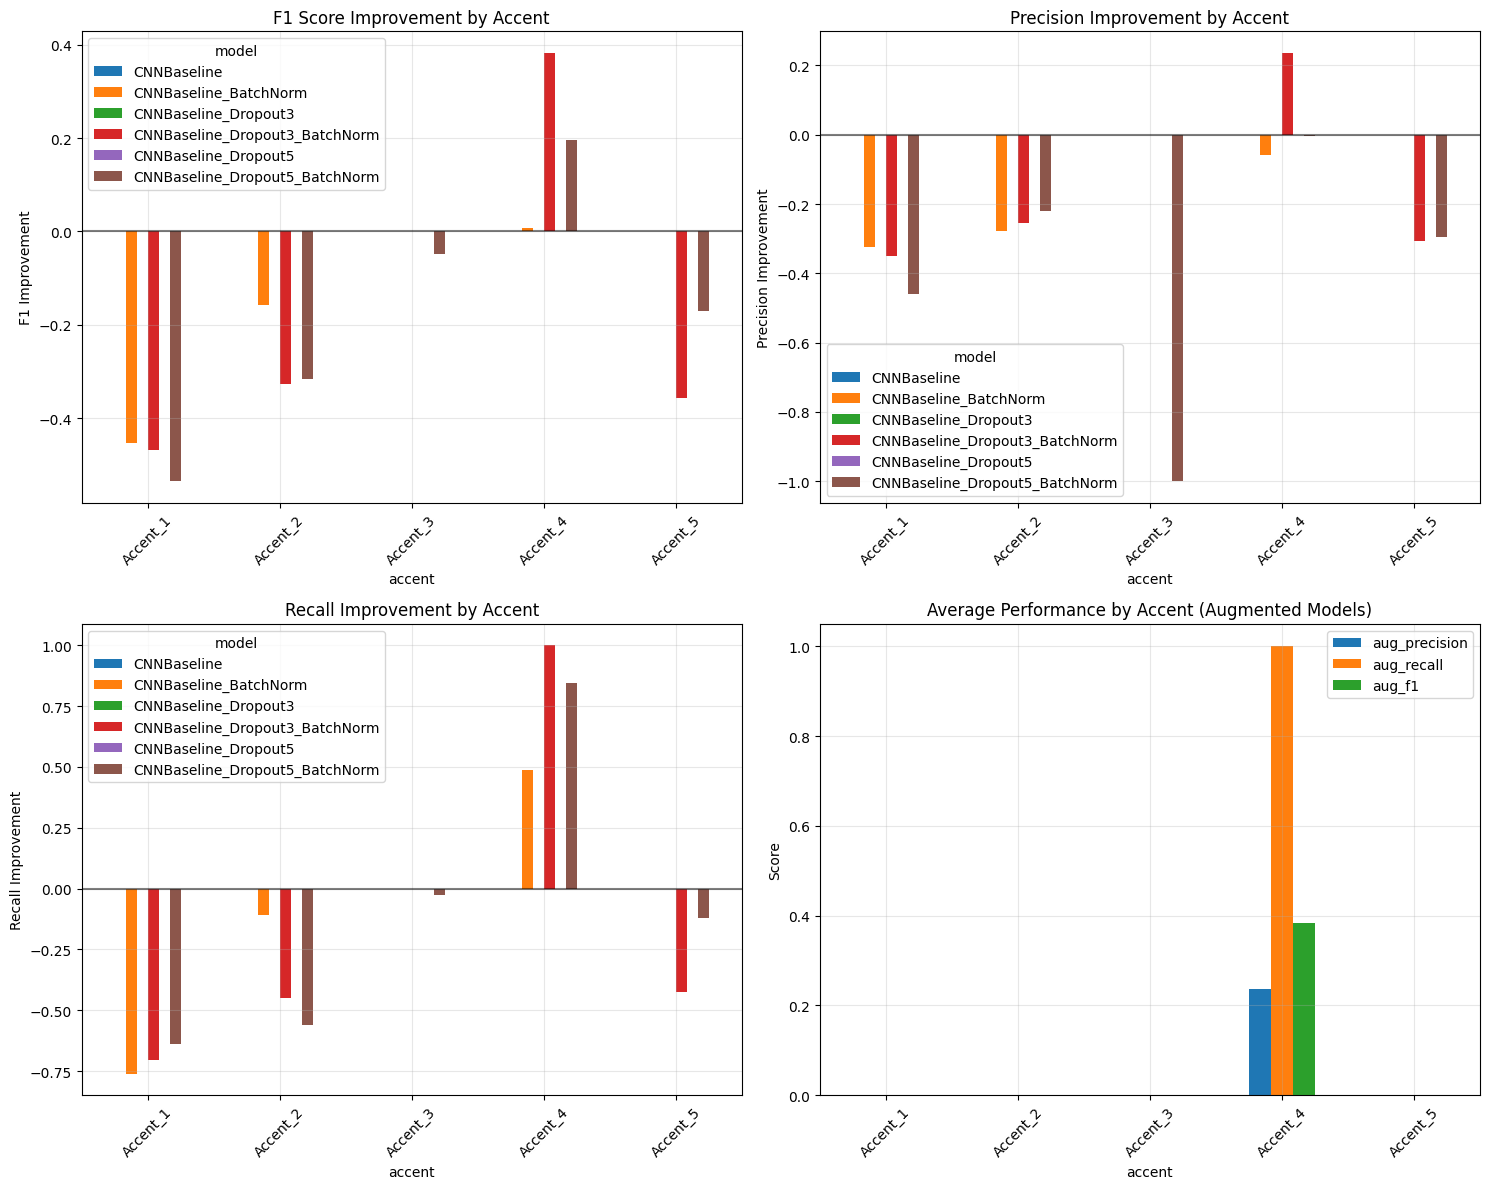


COMPARISON SUMMARY
                       model_name  non_aug_accuracy  aug_accuracy  \
0            CNNBaseline_Dropout5            0.2366        0.2366   
1  CNNBaseline_Dropout3_BatchNorm            0.3091        0.2366   
2           CNNBaseline_BatchNorm            0.3076        0.2366   
3            CNNBaseline_Dropout3            0.2366        0.2366   
4                     CNNBaseline            0.2366        0.2366   
5  CNNBaseline_Dropout5_BatchNorm            0.3044        0.2366   
6                     CNNBaseline            0.2366        0.2366   

   non_aug_precision  aug_precision  non_aug_recall  aug_recall  non_aug_f1  \
0             0.0473         0.0473          0.2000         0.2      0.0765   
1             0.1826         0.0473          0.3156         0.2      0.2300   
2             0.1792         0.0473          0.2769         0.2      0.1973   
3             0.0473         0.0473          0.2000         0.2      0.0765   
4             0.0473         0.0

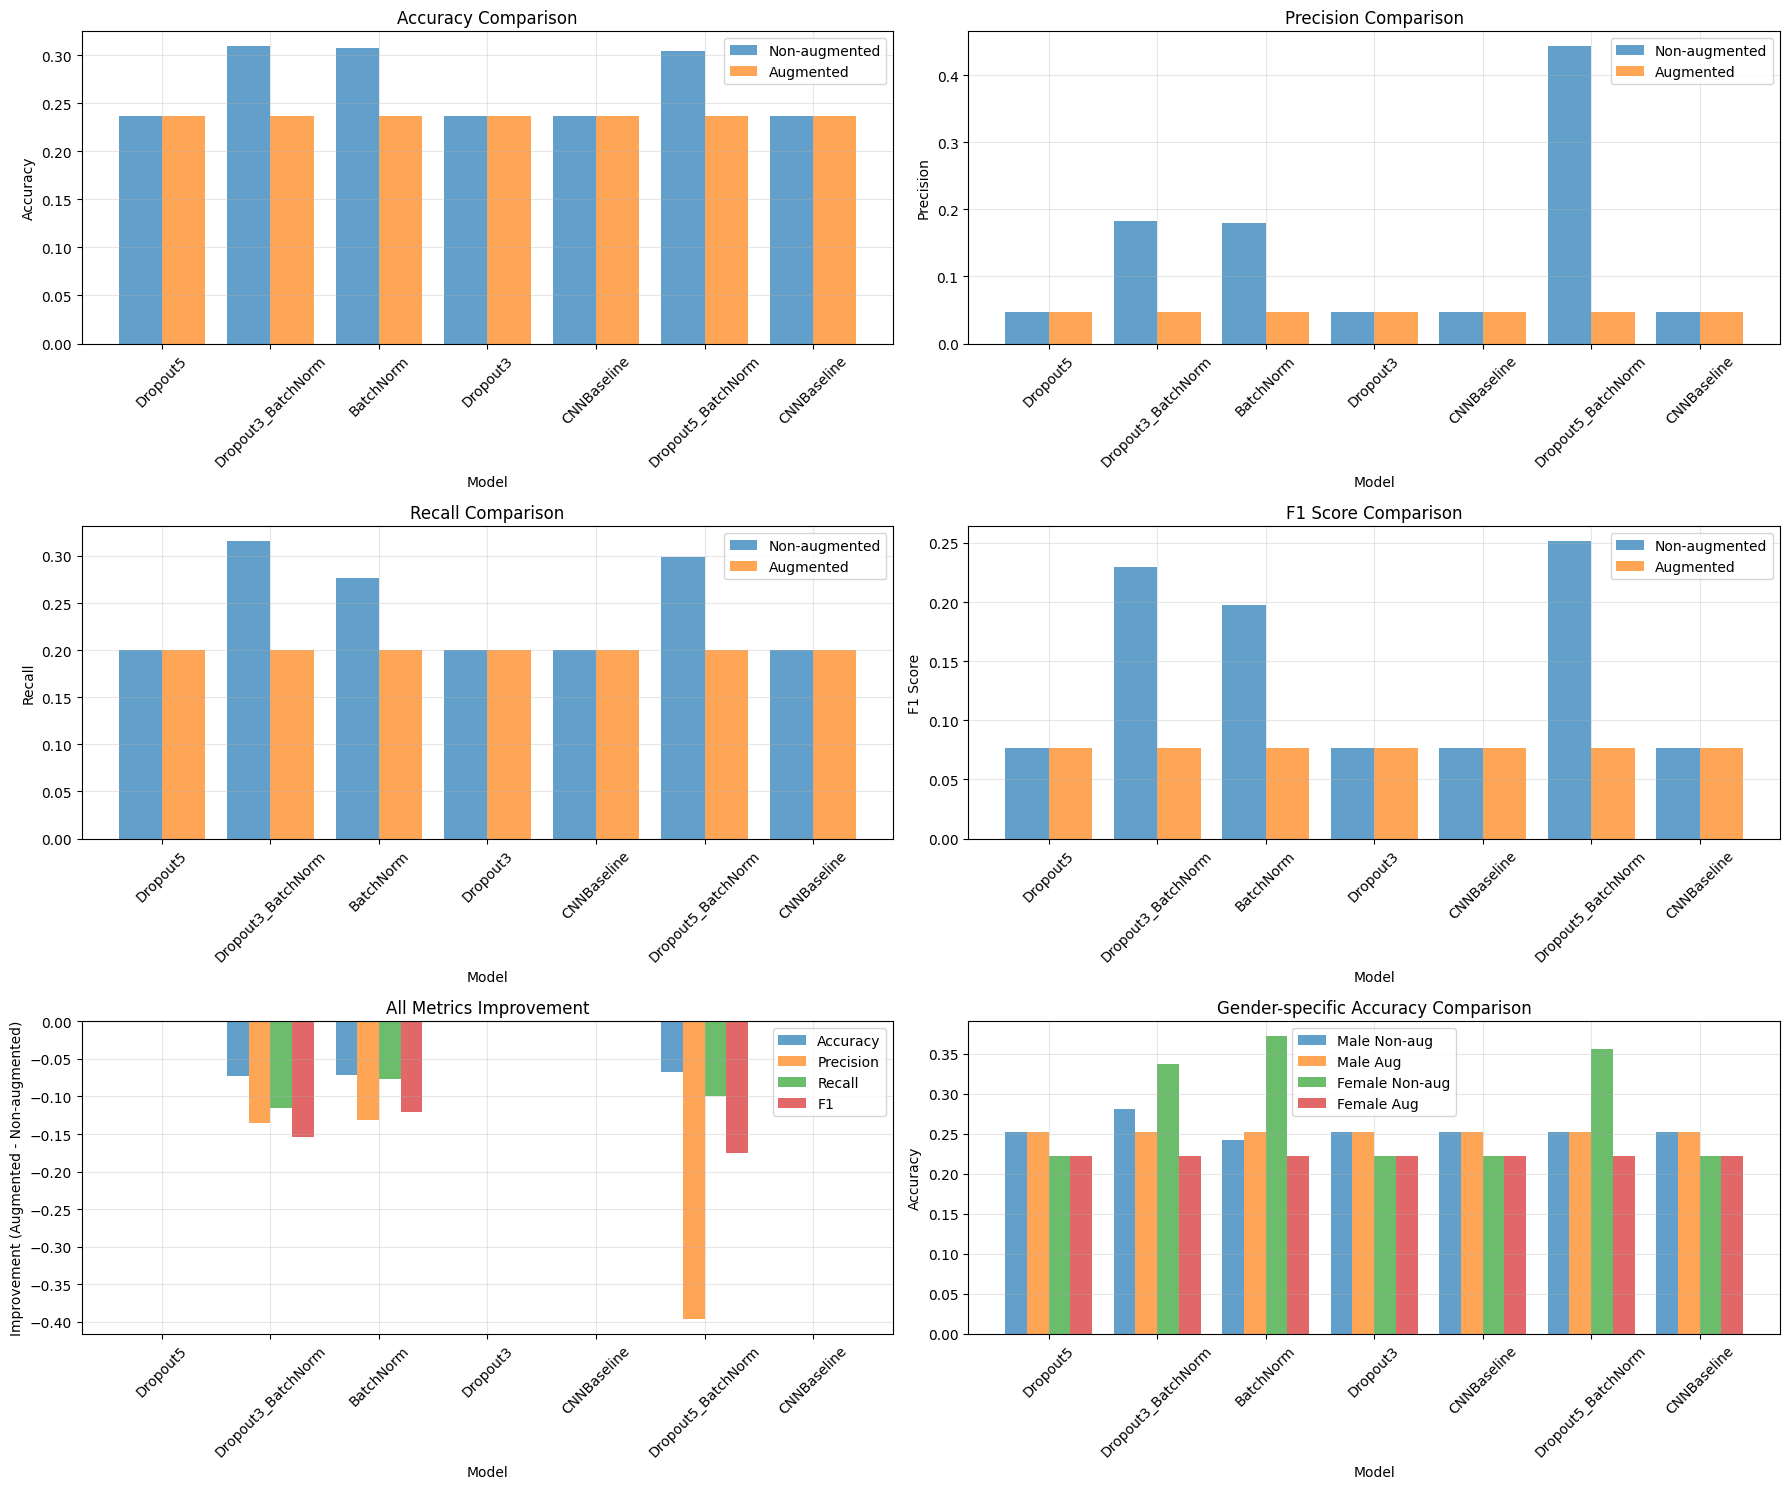


GENDER-SPECIFIC METRICS SUMMARY
                            Model  Male_NonAug_Acc  Male_Aug_Acc  \
0            CNNBaseline_Dropout5           0.2516        0.2516   
1  CNNBaseline_Dropout3_BatchNorm           0.2803        0.2516   
2           CNNBaseline_BatchNorm           0.2420        0.2516   
3            CNNBaseline_Dropout3           0.2516        0.2516   
4                     CNNBaseline           0.2516        0.2516   
5  CNNBaseline_Dropout5_BatchNorm           0.2516        0.2516   
6                     CNNBaseline           0.2516        0.2516   

   Male_Acc_Improve  Female_NonAug_Acc  Female_Aug_Acc  Female_Acc_Improve  \
0            0.0000             0.2219          0.2219              0.0000   
1           -0.0287             0.3375          0.2219             -0.1156   
2            0.0096             0.3719          0.2219             -0.1500   
3            0.0000             0.2219          0.2219              0.0000   
4            0.0000             

In [11]:
import os
import torch
import pandas as pd
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Setup paths and device
base_dir = "/Users/larsheijnen/DL"
non_aug_dir = os.path.join(base_dir, "saved_models", "A", "not_augmented_earlystop")
aug_dir = os.path.join(base_dir, "saved_models", "A", "augmented_earlystop")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Prepare test dataset for evaluation
test_dataset = AccentRawWaveformDataset(
    '/Users/larsheijnen/DL/Train',
    target_sr=16000,
    standardize=True
)

# Split dataset (same split as training for fair comparison)
train_len = int(0.8 * len(test_dataset))
test_len = len(test_dataset) - train_len
_, test_ds = random_split(test_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=pad_1d_collate, pin_memory=False)

# Model mapping function
def get_model_class_from_filename(fname):
    if fname.startswith("CNNBaseline_Dropout3_BatchNorm"):
        return CNNBaseline_Dropout3_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout5_BatchNorm"):
        return CNNBaseline_Dropout5_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout3"):
        return CNNBaseline_Dropout3
    elif fname.startswith("CNNBaseline_Dropout5"):
        return CNNBaseline_Dropout5
    elif fname.startswith("CNNBaseline_BatchNorm"):
        return CNNBaseline_BatchNorm
    elif fname.startswith("CNNBaseline"):
        return CNNBaseline
    return None

# NEW: Function to generate detailed classification reports
def generate_classification_reports(model, loader, device, model_name):
    """Generate classification reports for accent classes"""
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for specs, labels, _ in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    
    # Define accent class names (adjust based on your dataset)
    accent_names = ['Accent_1', 'Accent_2', 'Accent_3', 'Accent_4', 'Accent_5']
    
    print(f"\n" + "="*50)
    print(f"CLASSIFICATION REPORT - {model_name}")
    print("="*50)
    
    # Generate detailed classification report
    report = classification_report(
        all_labels, 
        all_preds, 
        target_names=accent_names,
        digits=4,
        output_dict=False
    )
    print(report)
    
    # Generate classification report as dictionary for further analysis
    report_dict = classification_report(
        all_labels, 
        all_preds, 
        target_names=accent_names,
        digits=4,
        output_dict=True
    )
    
    return report_dict

# Enhanced evaluation function with gender-specific metrics AND classification reports
def evaluate_model_comprehensive(model, loader, device, model_name=None, show_classification_report=False):
    model.eval()
    all_preds, all_labels, all_genders = [], [], []
    with torch.no_grad():
        for specs, labels, genders in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            all_genders.extend(genders)
    
    # Overall metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    # Generate classification report if requested
    classification_report_dict = None
    if show_classification_report and model_name:
        classification_report_dict = generate_classification_reports(model, loader, device, model_name)
    
    # Gender-specific metrics for all measures
    gender_results = {}
    for gender in ['m', 'f']:
        idxs = [i for i, g in enumerate(all_genders) if g == gender]
        if idxs:
            gender_preds = [all_preds[i] for i in idxs]
            gender_labels = [all_labels[i] for i in idxs]
            gender_acc = accuracy_score(gender_labels, gender_preds)
            gender_prec = precision_score(gender_labels, gender_preds, average='macro', zero_division=0)
            gender_recall = recall_score(gender_labels, gender_preds, average='macro')
            gender_f1 = f1_score(gender_labels, gender_preds, average='macro')
            gender_results[gender] = {
                'accuracy': gender_acc,
                'precision': gender_prec,
                'recall': gender_recall,
                'f1': gender_f1
            }
        else:
            gender_results[gender] = {
                'accuracy': 0.0,
                'precision': 0.0,
                'recall': 0.0,
                'f1': 0.0
            }
    
    result = {
        'accuracy': acc,
        'precision': prec,
        'recall': recall,
        'f1': f1,
        'male_accuracy': gender_results['m']['accuracy'],
        'male_precision': gender_results['m']['precision'],
        'male_recall': gender_results['m']['recall'],
        'male_f1': gender_results['m']['f1'],
        'female_accuracy': gender_results['f']['accuracy'],
        'female_precision': gender_results['f']['precision'],
        'female_recall': gender_results['f']['recall'],
        'female_f1': gender_results['f']['f1']
    }
    
    if classification_report_dict:
        result['classification_report'] = classification_report_dict
    
    return result

# Collect model files
non_aug_files = [f for f in os.listdir(non_aug_dir) if f.endswith(".pth") and "best" in f]
aug_files = [f for f in os.listdir(aug_dir) if f.endswith(".pth") and "best" in f]

print("Found non-augmented models:", non_aug_files)
print("Found augmented models:", aug_files)

# Extract model base names for comparison - FIXED VERSION
def extract_model_name(filename):
    """Extract the base model name from filename - order matters for correct matching"""
    # Check longer names first to avoid partial matches
    if "CNNBaseline_Dropout3_BatchNorm" in filename:
        return "CNNBaseline_Dropout3_BatchNorm"
    elif "CNNBaseline_Dropout5_BatchNorm" in filename:
        return "CNNBaseline_Dropout5_BatchNorm"
    elif "CNNBaseline_Dropout3" in filename:
        return "CNNBaseline_Dropout3"
    elif "CNNBaseline_Dropout5" in filename:
        return "CNNBaseline_Dropout5"
    elif "CNNBaseline_BatchNorm" in filename:
        return "CNNBaseline_BatchNorm"
    elif "CNNBaseline" in filename:
        return "CNNBaseline"
    return None

# Build comparison results
comparison_results = []
all_classification_reports = {}

# Find matching models - FIXED VERSION
for non_aug_file in non_aug_files:
    model_name = extract_model_name(non_aug_file)
    if model_name is None:
        continue
    
    # Find corresponding augmented model with exact matching
    aug_file = None
    for af in aug_files:
        if extract_model_name(af) == model_name:  # Exact match instead of substring
            aug_file = af
            break
    
    if aug_file is None:
        print(f"No augmented model found for {model_name}")
        continue
    
    print(f"\nComparing {model_name}:")
    print(f"  Non-augmented: {non_aug_file}")
    print(f"  Augmented: {aug_file}")
    
    # Get model class
    model_class = get_model_class_from_filename(non_aug_file)
    if model_class is None:
        print(f"  Could not determine model class for {non_aug_file}")
        continue
    
    # Evaluate non-augmented model WITH classification report
    model = model_class().to(device)
    model.load_state_dict(torch.load(os.path.join(non_aug_dir, non_aug_file), map_location=device))
    non_aug_metrics = evaluate_model_comprehensive(
        model, test_loader, device, 
        model_name=f"{model_name} (Non-Augmented)", 
        show_classification_report=True
    )
    
    # Evaluate augmented model WITH classification report
    model = model_class().to(device)
    model.load_state_dict(torch.load(os.path.join(aug_dir, aug_file), map_location=device))
    aug_metrics = evaluate_model_comprehensive(
        model, test_loader, device, 
        model_name=f"{model_name} (Augmented)", 
        show_classification_report=True
    )
    
    # Store classification reports for later analysis
    all_classification_reports[f"{model_name}_non_aug"] = non_aug_metrics.get('classification_report')
    all_classification_reports[f"{model_name}_aug"] = aug_metrics.get('classification_report')
    
    # Store results with all metrics
    comparison_results.append({
        'model_name': model_name,
        'non_aug_accuracy': non_aug_metrics['accuracy'],
        'aug_accuracy': aug_metrics['accuracy'],
        'non_aug_precision': non_aug_metrics['precision'],
        'aug_precision': aug_metrics['precision'],
        'non_aug_recall': non_aug_metrics['recall'],
        'aug_recall': aug_metrics['recall'],
        'non_aug_f1': non_aug_metrics['f1'],
        'aug_f1': aug_metrics['f1'],
        'non_aug_male_acc': non_aug_metrics['male_accuracy'],
        'aug_male_acc': aug_metrics['male_accuracy'],
        'non_aug_male_prec': non_aug_metrics['male_precision'],
        'aug_male_prec': aug_metrics['male_precision'],
        'non_aug_male_recall': non_aug_metrics['male_recall'],
        'aug_male_recall': aug_metrics['male_recall'],
        'non_aug_male_f1': non_aug_metrics['male_f1'],
        'aug_male_f1': aug_metrics['male_f1'],
        'non_aug_female_acc': non_aug_metrics['female_accuracy'],
        'aug_female_acc': aug_metrics['female_accuracy'],
        'non_aug_female_prec': non_aug_metrics['female_precision'],
        'aug_female_prec': aug_metrics['female_precision'],
        'non_aug_female_recall': non_aug_metrics['female_recall'],
        'aug_female_recall': aug_metrics['female_recall'],
        'non_aug_female_f1': non_aug_metrics['female_f1'],
        'aug_female_f1': aug_metrics['female_f1'],
        'accuracy_improvement': aug_metrics['accuracy'] - non_aug_metrics['accuracy'],
        'precision_improvement': aug_metrics['precision'] - non_aug_metrics['precision'],
        'recall_improvement': aug_metrics['recall'] - non_aug_metrics['recall'],
        'f1_improvement': aug_metrics['f1'] - non_aug_metrics['f1']
    })
    
    print(f"  Non-augmented - Acc: {non_aug_metrics['accuracy']:.4f}, Prec: {non_aug_metrics['precision']:.4f}, Recall: {non_aug_metrics['recall']:.4f}, F1: {non_aug_metrics['f1']:.4f}")
    print(f"  Augmented     - Acc: {aug_metrics['accuracy']:.4f}, Prec: {aug_metrics['precision']:.4f}, Recall: {aug_metrics['recall']:.4f}, F1: {aug_metrics['f1']:.4f}")
    print(f"  Improvement   - Acc: {aug_metrics['accuracy'] - non_aug_metrics['accuracy']:.4f}, Prec: {aug_metrics['precision'] - non_aug_metrics['precision']:.4f}, Recall: {aug_metrics['recall'] - non_aug_metrics['recall']:.4f}, F1: {aug_metrics['f1'] - non_aug_metrics['f1']:.4f}")

# NEW: Create accent-specific performance comparison
if all_classification_reports:
    print("\n" + "="*80)
    print("ACCENT-SPECIFIC PERFORMANCE ANALYSIS")
    print("="*80)
    
    accent_comparison = []
    accent_names = ['Accent_1', 'Accent_2', 'Accent_3', 'Accent_4', 'Accent_5']
    
    for model_name in [result['model_name'] for result in comparison_results]:
        non_aug_report = all_classification_reports.get(f"{model_name}_non_aug")
        aug_report = all_classification_reports.get(f"{model_name}_aug")
        
        if non_aug_report and aug_report:
            for accent in accent_names:
                if accent in non_aug_report and accent in aug_report:
                    accent_comparison.append({
                        'model': model_name,
                        'accent': accent,
                        'non_aug_precision': non_aug_report[accent]['precision'],
                        'aug_precision': aug_report[accent]['precision'],
                        'non_aug_recall': non_aug_report[accent]['recall'],
                        'aug_recall': aug_report[accent]['recall'],
                        'non_aug_f1': non_aug_report[accent]['f1-score'],
                        'aug_f1': aug_report[accent]['f1-score'],
                        'precision_improvement': aug_report[accent]['precision'] - non_aug_report[accent]['precision'],
                        'recall_improvement': aug_report[accent]['recall'] - non_aug_report[accent]['recall'],
                        'f1_improvement': aug_report[accent]['f1-score'] - non_aug_report[accent]['f1-score']
                    })
    
    if accent_comparison:
        accent_df = pd.DataFrame(accent_comparison)
        
        print("\nAccent-specific F1 Score Comparison:")
        accent_pivot = accent_df.pivot_table(
            index='accent', 
            columns='model', 
            values=['non_aug_f1', 'aug_f1', 'f1_improvement'],
            aggfunc='mean'
        )
        print(accent_pivot.round(4))
        
        # Plot accent-specific improvements
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # F1 improvement by accent
        accent_f1_pivot = accent_df.pivot_table(index='accent', columns='model', values='f1_improvement')
        accent_f1_pivot.plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('F1 Score Improvement by Accent')
        axes[0,0].set_ylabel('F1 Improvement')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Precision improvement by accent
        accent_prec_pivot = accent_df.pivot_table(index='accent', columns='model', values='precision_improvement')
        accent_prec_pivot.plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Precision Improvement by Accent')
        axes[0,1].set_ylabel('Precision Improvement')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Recall improvement by accent
        accent_recall_pivot = accent_df.pivot_table(index='accent', columns='model', values='recall_improvement')
        accent_recall_pivot.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Recall Improvement by Accent')
        axes[1,0].set_ylabel('Recall Improvement')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Average performance by accent (augmented models)
        avg_by_accent = accent_df.groupby('accent')[['aug_precision', 'aug_recall', 'aug_f1']].mean()
        avg_by_accent.plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Average Performance by Accent (Augmented Models)')
        axes[1,1].set_ylabel('Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Create DataFrame for easy analysis
if comparison_results:
    df_results = pd.DataFrame(comparison_results)
    print("\n" + "="*80)
    print("COMPARISON SUMMARY")
    print("="*80)
    print(df_results.round(4))

    # Enhanced summary statistics for all metrics
    print(f"\nOverall Statistics:")
    print(f"Average accuracy improvement: {df_results['accuracy_improvement'].mean():.4f} ± {df_results['accuracy_improvement'].std():.4f}")
    print(f"Average precision improvement: {df_results['precision_improvement'].mean():.4f} ± {df_results['precision_improvement'].std():.4f}")
    print(f"Average recall improvement: {df_results['recall_improvement'].mean():.4f} ± {df_results['recall_improvement'].std():.4f}")
    print(f"Average F1 improvement: {df_results['f1_improvement'].mean():.4f} ± {df_results['f1_improvement'].std():.4f}")
    print(f"Models with improved accuracy: {(df_results['accuracy_improvement'] > 0).sum()}/{len(df_results)}")
    print(f"Models with improved precision: {(df_results['precision_improvement'] > 0).sum()}/{len(df_results)}")
    print(f"Models with improved recall: {(df_results['recall_improvement'] > 0).sum()}/{len(df_results)}")
    print(f"Models with improved F1: {(df_results['f1_improvement'] > 0).sum()}/{len(df_results)}")

    # Find best models for all metrics
    best_non_aug = df_results.loc[df_results['non_aug_accuracy'].idxmax()]
    best_aug = df_results.loc[df_results['aug_accuracy'].idxmax()]
    most_improved_acc = df_results.loc[df_results['accuracy_improvement'].idxmax()]
    most_improved_f1 = df_results.loc[df_results['f1_improvement'].idxmax()]

    print(f"\nBest non-augmented model: {best_non_aug['model_name']} (Acc: {best_non_aug['non_aug_accuracy']:.4f})")
    print(f"Best augmented model: {best_aug['model_name']} (Acc: {best_aug['aug_accuracy']:.4f})")
    print(f"Most improved model (accuracy): {most_improved_acc['model_name']} (Improvement: {most_improved_acc['accuracy_improvement']:.4f})")
    print(f"Most improved model (F1): {most_improved_f1['model_name']} (Improvement: {most_improved_f1['f1_improvement']:.4f})")

    # Enhanced visualization with more metrics
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    
    x_pos = range(len(df_results))
    
    # Accuracy comparison
    axes[0,0].bar([x - 0.2 for x in x_pos], df_results['non_aug_accuracy'], 0.4, label='Non-augmented', alpha=0.7)
    axes[0,0].bar([x + 0.2 for x in x_pos], df_results['aug_accuracy'], 0.4, label='Augmented', alpha=0.7)
    axes[0,0].set_xlabel('Model')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_title('Accuracy Comparison')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Precision comparison
    axes[0,1].bar([x - 0.2 for x in x_pos], df_results['non_aug_precision'], 0.4, label='Non-augmented', alpha=0.7)
    axes[0,1].bar([x + 0.2 for x in x_pos], df_results['aug_precision'], 0.4, label='Augmented', alpha=0.7)
    axes[0,1].set_xlabel('Model')
    axes[0,1].set_ylabel('Precision')
    axes[0,1].set_title('Precision Comparison')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Recall comparison
    axes[1,0].bar([x - 0.2 for x in x_pos], df_results['non_aug_recall'], 0.4, label='Non-augmented', alpha=0.7)
    axes[1,0].bar([x + 0.2 for x in x_pos], df_results['aug_recall'], 0.4, label='Augmented', alpha=0.7)
    axes[1,0].set_xlabel('Model')
    axes[1,0].set_ylabel('Recall')
    axes[1,0].set_title('Recall Comparison')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # F1 comparison
    axes[1,1].bar([x - 0.2 for x in x_pos], df_results['non_aug_f1'], 0.4, label='Non-augmented', alpha=0.7)
    axes[1,1].bar([x + 0.2 for x in x_pos], df_results['aug_f1'], 0.4, label='Augmented', alpha=0.7)
    axes[1,1].set_xlabel('Model')
    axes[1,1].set_ylabel('F1 Score')
    axes[1,1].set_title('F1 Score Comparison')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # All improvements in one chart
    width = 0.2
    axes[2,0].bar([x - 1.5*width for x in x_pos], df_results['accuracy_improvement'], width, label='Accuracy', alpha=0.7)
    axes[2,0].bar([x - 0.5*width for x in x_pos], df_results['precision_improvement'], width, label='Precision', alpha=0.7)
    axes[2,0].bar([x + 0.5*width for x in x_pos], df_results['recall_improvement'], width, label='Recall', alpha=0.7)
    axes[2,0].bar([x + 1.5*width for x in x_pos], df_results['f1_improvement'], width, label='F1', alpha=0.7)
    axes[2,0].set_xlabel('Model')
    axes[2,0].set_ylabel('Improvement (Augmented - Non-augmented)')
    axes[2,0].set_title('All Metrics Improvement')
    axes[2,0].set_xticks(x_pos)
    axes[2,0].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[2,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[2,0].legend()
    axes[2,0].grid(True, alpha=0.3)
    
    # Gender-specific accuracy comparison
    male_non_aug = df_results['non_aug_male_acc'].values
    male_aug = df_results['aug_male_acc'].values
    female_non_aug = df_results['non_aug_female_acc'].values
    female_aug = df_results['aug_female_acc'].values
    
    x_pos_gender = range(len(df_results))
    width = 0.2
    axes[2,1].bar([x - 1.5*width for x in x_pos_gender], male_non_aug, width, label='Male Non-aug', alpha=0.7)
    axes[2,1].bar([x - 0.5*width for x in x_pos_gender], male_aug, width, label='Male Aug', alpha=0.7)
    axes[2,1].bar([x + 0.5*width for x in x_pos_gender], female_non_aug, width, label='Female Non-aug', alpha=0.7)
    axes[2,1].bar([x + 1.5*width for x in x_pos_gender], female_aug, width, label='Female Aug', alpha=0.7)
    
    axes[2,1].set_xlabel('Model')
    axes[2,1].set_ylabel('Accuracy')
    axes[2,1].set_title('Gender-specific Accuracy Comparison')
    axes[2,1].set_xticks(x_pos_gender)
    axes[2,1].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[2,1].legend()
    axes[2,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional detailed gender-specific metrics table
    print("\n" + "="*80)
    print("GENDER-SPECIFIC METRICS SUMMARY")
    print("="*80)
    
    gender_metrics_summary = []
    for _, row in df_results.iterrows():
        gender_metrics_summary.append({
            'Model': row['model_name'],
            'Male_NonAug_Acc': row['non_aug_male_acc'],
            'Male_Aug_Acc': row['aug_male_acc'],
            'Male_Acc_Improve': row['aug_male_acc'] - row['non_aug_male_acc'],
            'Female_NonAug_Acc': row['non_aug_female_acc'],
            'Female_Aug_Acc': row['aug_female_acc'],
            'Female_Acc_Improve': row['aug_female_acc'] - row['non_aug_female_acc'],
            'Male_NonAug_F1': row['non_aug_male_f1'],
            'Male_Aug_F1': row['aug_male_f1'],
            'Male_F1_Improve': row['aug_male_f1'] - row['non_aug_male_f1'],
            'Female_NonAug_F1': row['non_aug_female_f1'],
            'Female_Aug_F1': row['aug_female_f1'],
            'Female_F1_Improve': row['aug_female_f1'] - row['non_aug_female_f1']
        })
    
    gender_df = pd.DataFrame(gender_metrics_summary)
    print(gender_df.round(4))

else:
    print("No matching models found for comparison!")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)